# Feature Extraction

## Сбор данных

In [1]:
%pylab inline
import twitter
import time
import os
from pprint import pprint 

CONSUMER_KEY = "YuPZpGFwYIuozchukUq8HJjSo"
CONSUMER_SECRET = "ejXbxQnh4mYT95U80lmKuf1fplQmr7UkgqDTDJjfMAAoGZemuz"

ACCESS_TOKEN_KEY = "703233763111780352-B4pLHq5RQTQqRSQRWDNUqtksu7bIspP"
ACCESS_TOKEN_SECRET = "N3JkQVBR27P7oqfV2BZmDkT1lypMoe52KBXUDnSFRQrWO"

api = twitter.Api(consumer_key=CONSUMER_KEY, 
                  consumer_secret=CONSUMER_SECRET, 
                  access_token_key=ACCESS_TOKEN_KEY, 
                  access_token_secret=ACCESS_TOKEN_SECRET)

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
from collections import defaultdict
import json
from sklearn.feature_extraction import DictVectorizer


TRAINING_SET_URL = "twitter_train.txt"
EXAMPLE_SET_URL = "twitter_example.txt"
df_users_train = pd.read_csv(TRAINING_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex = pd.read_csv(EXAMPLE_SET_URL, sep=",", header=0, names=["uid", "cat"])
df_users_ex['cat'] = None
df_users = pd.concat([df_users_train, df_users_ex])
print df_users

             uid  cat
0       40585382    1
1       30005269    0
2     3314758074    0
3       14311688    0
4      110457801    0
5      269062860    1
6     1656126090    0
7      758669826    1
8       21056856    1
9      954363313    1
10     337284868    1
11     203541550    1
12     156333623    1
13     587865313    0
14    4750028375    0
15     115703194    0
16      15475471    1
17    2701352961    0
18     383978282    1
19    1031038448    0
20     115402745    0
21     168516256    1
22     293602749    1
23    2734365015    1
24      45025729    0
25     183825988    0
26     954537696    0
27     187838951    0
28      13134132    0
29     142082006    0
...          ...  ...
1868  4307235683  NaN
1869    38527519  NaN
1870    16970757  NaN
1871  1258209258  NaN
1872   366939898  NaN
1873   198488053  NaN
1874    41016473  NaN
1875   326944732  NaN
1876   298915258  NaN
1877    49035017  NaN
1878  2216018301  NaN
1879   901209434  NaN
1880  1380718279  NaN
1881  3272

In [3]:
def sort_user_tweets(user_id):
    """download tweetls and remove unnecessary"""
    statuses = api.GetUserTimeline(user_id, count = 200, include_rts=False, exclude_replies=True, trim_user=True) 
    res_statuses = []
    for status in statuses:
        #remove tweets with media and links, to leave with the mention of other users (may be obtained meaningful tokens)
        if status.media or status.urls:
            continue
        if status.possibly_sensitive and (status.possibly_sensitive == True):
            continue
        res_statuses.append(status.AsDict())
        
    return res_statuses

In [4]:
#create the list of processed users
processed_users = set()
file_name = 'processed_users'
if os.path.exists(file_name):
    with open(file_name) as pr_user:
        for line in pr_user:
            processed_users.add(int(line))

In [5]:
pr_user = open('processed_users', 'a')

cnt = 0;
for i in df_users["uid"]:
    cnt = cnt + 1
    if i not in processed_users:
        try:
            list_tweet = sort_user_tweets(i)
            f = open('tweets/' + str(i), 'w')
            json.dump(list_tweet, f)
            json.dump(i, pr_user)
            pr_user.write('\n')
            print cnt, " write"
            f.close()
        except Exception as error:
            print error
            if error.message == "Not authorized." or ("code" in error[0][0] and error[0][0]["code"] == 34):
                print "catch"
                continue
            if ("code" in error[0][0] and error[0][0]["code"] == 88):  #Rate Limit exceeded
                sleep_time = int(api.GetSleepTime("statuses/user_timeline"))
                if (sleep_time > 0):
                    print "sleep:", sleep_time
                    time.sleep(sleep_time)
                print "awake"
            continue
    else: 
        print cnt, " already"
        
pr_user.close()  

1  already
2  already
3  already
4  already
5  already
6  already
7  already
8  already
9  already
10  already
11  already
12  already
13  already
14  already
15  already
16  already
17  already
18  already
19  already
20  already
21  already
22  already
23  already
24  already
25  already
26  already
27  already
28  already
29  already
30  already
31  already
32  already
33  already
34  already
35  already
36  already
37  already
38  already
39  already
40  already
41  already
42  already
43  already
44  already
45  already
46  already
47  already
48  already
49  already
50  already
51  already
52  already
53  already
54  already
55  already
56  already
57  already
58  already
59  already
60  already
61  already
62  already
63  already
64  already
65  already
66  already
67  already
68  already
69  already
70  already
71  already
72  already
73  already
74  already
75  already
76  already
77  already
78  already
79  already
80  already
81  already
82  already
83  already
84  already
8

KeyboardInterrupt: 

In [ ]:
pr_user.close()  

In [6]:
def get_user_tweets(user_id):
    if user_id in processed_users:
        inp = open('tweets/' + str(user_id), 'r')
        tweets = json.loads(inp.readline())
        inp.close()
        return tweets
    else:
        return []

## Разбор текста твита

In [23]:
#хочется посмотреть, на каких языках и сколько твитов написано
file_name = 'processed_users'
dict_lang = {}
f = open(file_name, 'r')
cnt = 0
for line in f:    
    inp = open('tweets/' + line[:-1], 'r')
    if cnt == 6825:
        print 'tweets/' + line[:-1]
    tweets = json.loads(inp.readline())
    for tweet in tweets:
        if tweet["lang"] in dict_lang:
            dict_lang[tweet["lang"]] = dict_lang[tweet["lang"]] + 1
        else:
            dict_lang[tweet["lang"]] = 1
    inp.close()
for keys in dict_lang.keys():
    print keys, ": ", dict_lang[keys] 
f.close()

el :  5
en :  333333
zh :  14
vi :  5
is :  16
it :  130
iw :  7
eu :  30
cy :  118
ar :  361
in :  421
cs :  23
et :  197
es :  741
ru :  3
nl :  176
pt :  161
no :  62
tr :  54
lt :  30
lv :  21
tl :  629
pa :  1
th :  39
ro :  159
pl :  112
fr :  421
bn :  2
de :  310
ht :  216
hu :  27
fa :  1
hi :  93
fi :  37
da :  93
ja :  5
ko :  5
sv :  84
und :  3773
sl :  5


In [9]:
import re
def get_words(text):
    text = text.lower()
    """returns list of words"""
    #find = re.findall(r'[^\\=\-?~$%&/\[\]+><{}^(@)*#\s!,.":;_0-9]+', text)
    find = re.findall(r'#?[\d\w\']+', text)
    find = [s[1:] if s[0] == '#' else s[:] for s in find ]
    return find

In [10]:
print get_words("1#2015elect it's [y\ou] su\f-fe999r -wit^h @depre'ss(sion, #anx&iet?y or any other #mentalhealth challenge please know many others share your pain. You're not alone.LGBT #gay")

['1', '2015elect', "it's", 'y', 'ou', 'su', 'fe999r', 'wit', 'h', "depre'ss", 'sion', 'anx', 'iet', 'y', 'or', 'any', 'other', 'mentalhealth', 'challenge', 'please', 'know', 'many', 'others', 'share', 'your', 'pain', "you're", 'not', 'alone', 'lgbt', 'gay']


In [11]:
import nltk

nltk.download("wordnet")
nltk.download("stopwords")

[nltk_data] Downloading package wordnet to /home/dzl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/dzl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [12]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer
print stopwords.fileids()

[u'danish', u'dutch', u'english', u'finnish', u'french', u'german', u'hungarian', u'italian', u'norwegian', u'portuguese', u'russian', u'spanish', u'swedish', u'turkish']


In [13]:
wnl = WordNetLemmatizer()
stemmer = SnowballStemmer("english")
list_stopwords = stopwords.words()

In [14]:
#WordNetLemmatizer не очень хорошо работает, если не указывать часть речи. Поэтому для английских слов(а их большинство)
#пробую применить Snowball stemmer 
def get_tokens(words):
    """returns list of tokens"""
    list_tokens = [stemmer.stem(wnl.lemmatize(word)) for word in words if wnl.lemmatize(word) not in list_stopwords]
    return list_tokens

In [15]:
print get_tokens(["here", "are", "clinton", "cats", "cats", "running"])

[u'clinton', u'cat', u'cat', u'run']


Необходимо реализовать функцию `get_tweet_tokens(tweet)`. Входной параметр - текст твита. Возвращаемое значение -- токены твита. 

In [16]:
def get_tweet_tokens(tweet):
    return get_tokens(get_words(tweet))

In [17]:
print get_tweet_tokens("Here are differents words")

[u'differ', u'word']


In [18]:
list_noise = ['http', 'don\'t', 'amp', 'i\'m', 'get', 'it', 'go']
print "don't" in list_noise

True


In [19]:
def collect_users_tokens(df_users):
    """returns users list and list of user dicts. Each dict contains frequence of user tokens"""
    list_users = []
    list_dict_tokens = []
    
    cnt = 0;
    for user in df_users.uid:
        cnt = cnt + 1
        print cnt
        user_tweets = get_user_tweets(user)
        list_users.append(user)
        dict_tokens = {}
        for tweet in user_tweets:
            list_tokens = get_tweet_tokens(tweet["text"])
            for token in list_tokens:
                if (token in dict_tokens):
                    dict_tokens[token] =  dict_tokens[token] + 1
                else:
                    #if len(token) > 1 and (token not in list_noise):
                    if len(token) > 2 and (len(token) < 11) and (token not in list_noise):
                    #if len(token) > 2 and (len(token) < 8) and (token not in list_noise):
                        dict_tokens[token] = 1
        list_dict_tokens.append(dict_tokens)
        
    return list_users, list_dict_tokens


In [20]:
from sklearn.feature_extraction import DictVectorizer
users, users_tokens = collect_users_tokens(df_users)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [21]:
print len(users), len(users_tokens)
v = DictVectorizer()
vs = v.fit_transform(users_tokens)

6898 6898


In [35]:
print v.feature_names_

[u"''''", u"'''''''''", u"'come", u"'don't", u"'faith", u"'i'm", u"'i'v", u"'jeremi", u"'lovesexi", u"'mi", u"'screw", u"'she", u"'there", u"'ur'", u"'we", u"'woman", u"0'clock", u'000', u'0000', u'0000012831', u'00001', u'00001010', u'00006', u'0001', u'000ft', u'000job', u'000k', u'000s', u'000th', u'000x', u'001', u'00100000', u'00100111', u'00101110', u'00110000', u'00110100', u'00111011', u'0013', u'002', u'003', u'004', u'005', u'006', u'0063', u'007', u'0070', u'0071608621', u'007dipper', u'008', u'009', u'00a', u'00akmw', u'00am', u'00latt', u'00p', u'00pm', u'00s', u'010', u'01000010', u'01000101', u'01001000', u'01001100', u'01001111', u'01010010', u'0103', u'0103lrl', u'0106', u'01100001', u'01100010', u'01100011', u'01100100', u'01100101', u'01100110', u'01100111', u'01101000', u'01101001', u'01101011', u'01101100', u'01101101', u'01101110', u'01101111', u'0111', u'01110000', u'01110010', u'01110011', u'01110100', u'01110101', u'01110111', u'01111000', u'01111001', u'0118',

In [36]:
len(v.feature_names_)

110245

In [57]:
print v
#print v.get_feature_names()
print len(v.get_feature_names())
pprint (users_tokens[:10])

DictVectorizer(dtype=<type 'numpy.float64'>, separator='=', sort=True,
        sparse=True)
40725
[{u'aca': 1,
  u'animalright': 13,
  u'anxieti': 1,
  u'art': 3,
  u'atheism': 5,
  u'atheist': 4,
  u'canada': 1,
  u'ctl': 1,
  u'depress': 1,
  u'enoughalreadi': 1,
  u'equal': 26,
  u'gay': 4,
  u'humanright': 18,
  u'lgbt': 15,
  u'love': 2,
  u'mentalhealth': 1,
  u'navyyardshoot': 2,
  u'nowaynra': 1,
  u'obamacar': 1,
  u'p2': 22,
  u'sept11': 1,
  u'shutdownthegop': 1,
  u'spiritu': 4,
  u'topprog': 5,
  u'uniteblu': 10,
  u'vote': 1,
  u'woman': 6,
  u'write': 3,
  u'wtc': 1},
 {u'21': 1,
  u'allovertheplac': 1,
  u'bachelor': 1,
  u'cap': 6,
  u'capsflyer': 1,
  u'capswin': 1,
  u'closeitout': 1,
  u'delay': 1,
  u'faa': 2,
  u'getonefororlov': 1,
  u'greta3500': 1,
  u'hockey': 1,
  u'i95miracl': 1,
  u'itjustmakessens': 1,
  u'letsgocap': 3,
  u'mapleleaf': 1,
  u'mvp': 1,
  u'nhl': 1,
  u'nhlallstar': 2,
  u'nhlbreakawayn': 1,
  u'ovi': 1,
  u'pigsonanisland': 1,
  u'redlin':

Сохраним полученные данные в файл. Используется метод savez из numpy. 

In [22]:
import numpy as np
np.savez("out_4.dat", data=vs, users=users, users_tokens=users_tokens, features_names = v.feature_names_)

Далее для получения представления о полученной информацию о токенах предлагается отобразить ее в виде облака тэгов. [Подсказка](http://anokhin.github.io/img/tag_cloud.png). 

In [136]:
list_feq = vs.sum(axis = 0)
list_feq = list_feq.tolist()[0]
print len(list_feq)
tokens_feq = zip(v.get_feature_names(), list_feq)

145058


In [137]:
from os import path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

def draw_tag_cloud(v, vs):
    """Draws tag cloud of found tokens"""

    mask = np.array(Image.open(path.join("/home/dzl/Technosfera/Data Mining/HW_4", "logo.png")))

    wc = WordCloud(background_color="white", max_words=1000, mask=mask,  stopwords=("http"))
    
    wc.generate_from_frequencies(tokens_feq)

    wc.to_file(path.join("/home/dzl/Technosfera/Data Mining/HW_4", "logo_1.png"))
    
    plt.figure(figsize = (12, 12))
    plt.imshow(wc)
    plt.axis("off")
    
    """plt.imshow(mask, cmap=plt.cm.gray)  
    plt.axis("off")"""
    plt.show()
    return

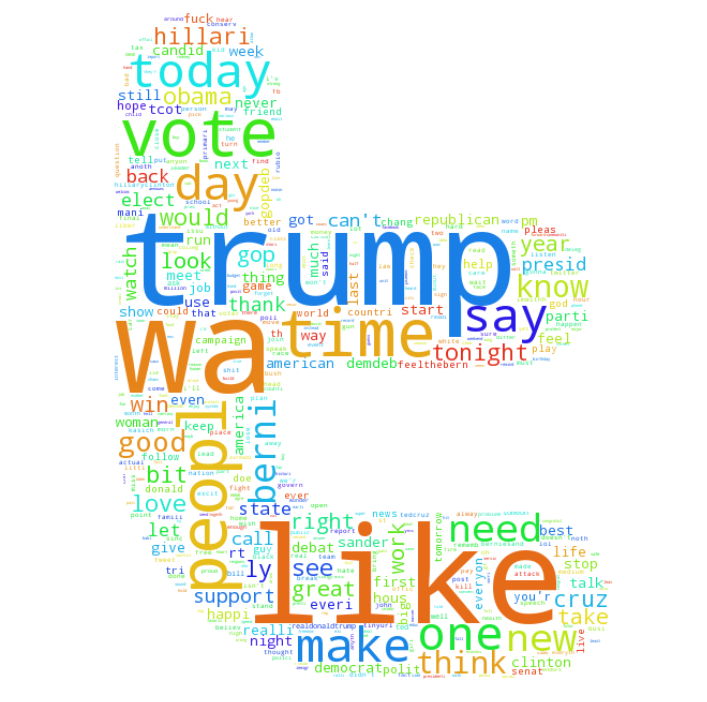

In [138]:
draw_tag_cloud(v, vs)